### Denoising-style Reverse Diffusion 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch,torchvision
from torch import nn
import torch.nn.functional as F
np.set_printoptions(precision=2)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rc('xtick',labelsize=5); plt.rc('ytick',labelsize=5)
print ("Ready.")

Ready.


### Util codes

In [2]:
from scipy.spatial import distance
def kernel_se(x1,x2,hyp={'gain':1.0,'len':1.0}):
    """ Squared-exponential kernel function """
    D = distance.cdist(x1/hyp['len'],x2/hyp['len'],'sqeuclidean')
    K = hyp['gain']*np.exp(-D)
    return K
def np2torch(x_np,dtype=torch.float32,device='cpu'):
    x_torch = torch.tensor(x_np,dtype=dtype,device=device)
    return x_torch
def torch2np(x_torch):
    x_np = x_torch.detach().cpu().numpy() # ndarray
    return x_np
def gather_and_reshape(values,steps,x_shape):
    values_gather = torch.gather(input=values,dim=-1,index=steps.cpu())
    n_batch = steps.shape[0]
    out_shape = (n_batch,) + ((1,)*(len(x_shape)-1))
    values_gather_reshape = values_gather.reshape(shape=out_shape)
    return values_gather_reshape.to(steps.device)
print ("Ready")

Ready


`DDPM` Equations \
Forward diffusion process:
$$q(x_t|x_{t-1}) = \mathcal{N}\left(x_t; ~\sqrt{1-\beta_t}x_{t-1}, \beta_t I \right)$$
$$q(x_t|x_0) = \mathcal{N}\left( x_t; \sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t) I \right)$$ 
where $\bar{\alpha}_t = \prod_{s=1}^t (1-\beta_s)$

Reverse diffusion process posterior:
$$ 
q(x_{t-1}|x_t,x_0) = \mathcal{N}
\left(
x_{t-1}; \frac{\beta_t \sqrt{\bar{\alpha}_{t-1}}}{(1-\bar{\alpha}_t)} x_0
+
\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \sqrt{\alpha_t} x_t,
\frac{\beta_t (1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}
\right)
$$

Default DDPM Hyper-parameters:
$\beta_1 = 10^{-4}$, $\beta_T = 0.02$, $T=1,000$ 

Ready.


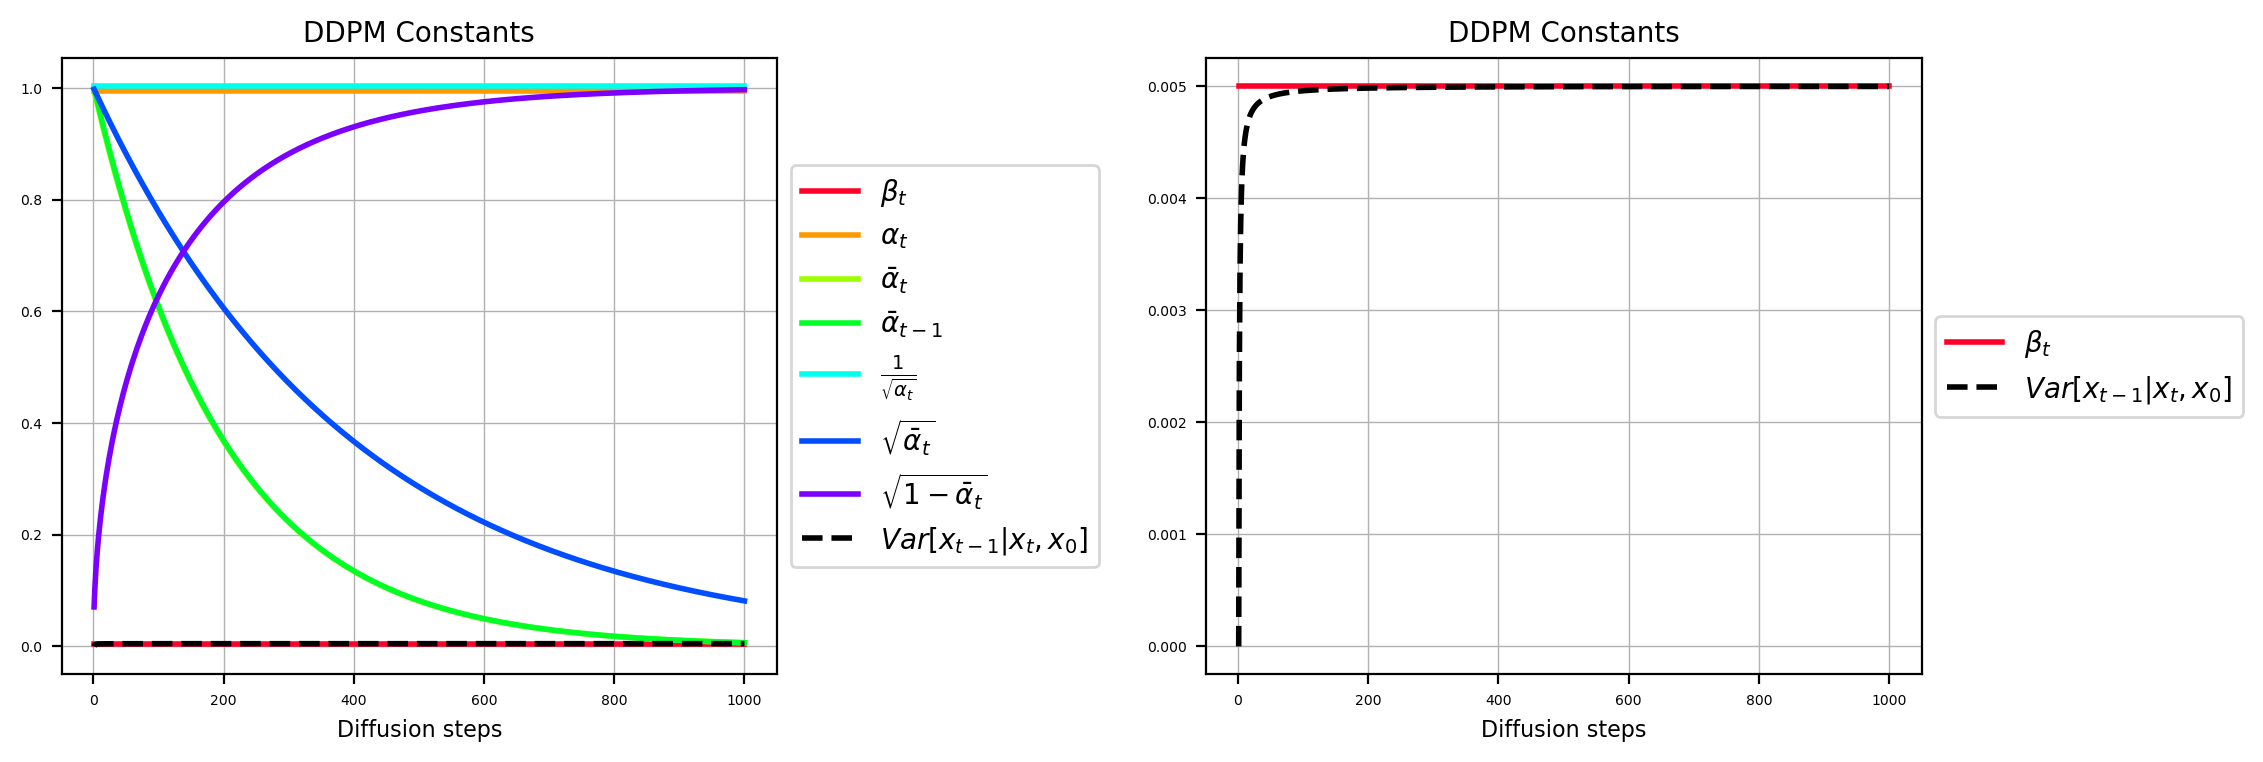

In [3]:
# Precompute some constants for DDPM
dc = {}
dc['T'] = 1000
dc['betas'] = torch.linspace(start=0.005,end=0.005,steps=dc['T']) # [T]
dc['alphas'] = 1.0 - dc['betas'] # [T]
dc['alphas_bar'] = torch.cumprod(dc['alphas'],axis=0) # [T]
dc['alphas_bar_prev'] = torch.nn.functional.pad(dc['alphas_bar'][:-1],pad=(1,0),value=1.0) # [T]
dc['sqrt_recip_alphas'] = torch.sqrt(1.0/dc['alphas']) # [T]
dc['sqrt_alphas_bar'] = torch.sqrt(dc['alphas_bar']) # [T]
dc['sqrt_one_minus_alphas_bar'] = torch.sqrt(1.0-dc['alphas_bar']) # [T]
dc['posterior_variance'] = dc['betas']*(1.0-dc['alphas_bar_prev'])/(1.0-dc['alphas_bar']) # [T]
print ("Ready.")
# Plot
ts = np.linspace(start=1,stop=dc['T'],num=dc['T'])
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,8)]
lw = 2 # linewidth
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas']),color=cs[1],label=r'$\alpha_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar']),color=cs[2],label=r'$\bar{\alpha}_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar_prev']),color=cs[3],label=r'$\bar{\alpha}_{t-1}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_recip_alphas']),color=cs[4],label=r'$\frac{1}{\sqrt{\alpha_t}}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_alphas_bar']),color=cs[5],label=r'$\sqrt{\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_one_minus_alphas_bar']),color=cs[6],label=r'$\sqrt{1-\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('DDPM Constants',fontsize=10); plt.grid(lw=0.5);
plt.subplot(1,2,2)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('DDPM Constants',fontsize=10); plt.grid(lw=0.5); 
plt.subplots_adjust(wspace=0.6); plt.show()

### `Algorithm 1` Training
1: $\mathbf{x}_0 \sim q( \mathbf{x}_0 )$ \
2: $t \sim \text{Uniform}(\{ 1, \ldots, T \})$ \
3: $ \boldsymbol{\color{red} \epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ \
4: Take gradient descent step on 
$$ 
    \nabla \| \boldsymbol{\color{red} \epsilon} - \boldsymbol{\epsilon}_{\theta}(
        \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t} \boldsymbol{\color{red} \epsilon}, t
        ) \|^2
$$

### `Algorithm 2` Sampling
1: $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ \
2: for $t=T,\ldots,1$ do \
3: $\quad$ $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ if $t>1$, else $\mathbf{z}=\mathbf{0}$ \
4: $\quad$ $\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}}
        \left(
            \mathbf{x}_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}
            \boldsymbol{\epsilon}_{\theta}(\mathbf{x},t)
        \right)
        + \sigma_t \mathbf{z}
    $ \
5: end for \
6: return $\mathbf{x}_0$

### Forward diffusion sampler

In [4]:
def forward_hilbert_diffusion_sample(x_0,K_chols,steps,dc,noise_rate=1.0):
    """
        x_0: torch.Tensor [B x D x L]
        K_chols: torch.Tensor [D x L x L]
        steps: torch.Tensor [B]
        dc: dictionary
        noise_rate: float (0.0~1.0)
    """
    sqrt_alphas_bar_t = gather_and_reshape(
        values=dc['sqrt_alphas_bar'],steps=steps,x_shape=x_0.shape) # [B x 1 x 1]
    sqrt_one_minus_alphas_bar_t = gather_and_reshape(
        values=dc['sqrt_one_minus_alphas_bar'],steps=steps,x_shape=x_0.shape) # [B x 1 x 1]
    x_t_mean = sqrt_alphas_bar_t * x_0 # [B x D x L]
    x_t_std = sqrt_one_minus_alphas_bar_t # [B x D x L]
    # Correlated noise sampling 
    noise = torch.randn_like(input=x_0) # [B x D x L]
    noise_expand = noise[:,:,:,None] # [B x D x L x 1]
    K_chols_torch_tile = torch.tile(input=K_chols,dims=(x_0.shape[0],1,1,1)) # [B x D x L x L]
    correlated_noise_permuted = K_chols_torch_tile @ noise_expand # [B x D x L x 1]
    correlated_noise_squeeze = correlated_noise_permuted.squeeze(dim=3) # [B x D x L]
    # Sample with correlated noise
    x_t = x_t_mean + noise_rate*x_t_std*correlated_noise_squeeze # [B x D x L]
    return x_t,correlated_noise_squeeze # [B x D x L]
print ("Ready.")

Ready.


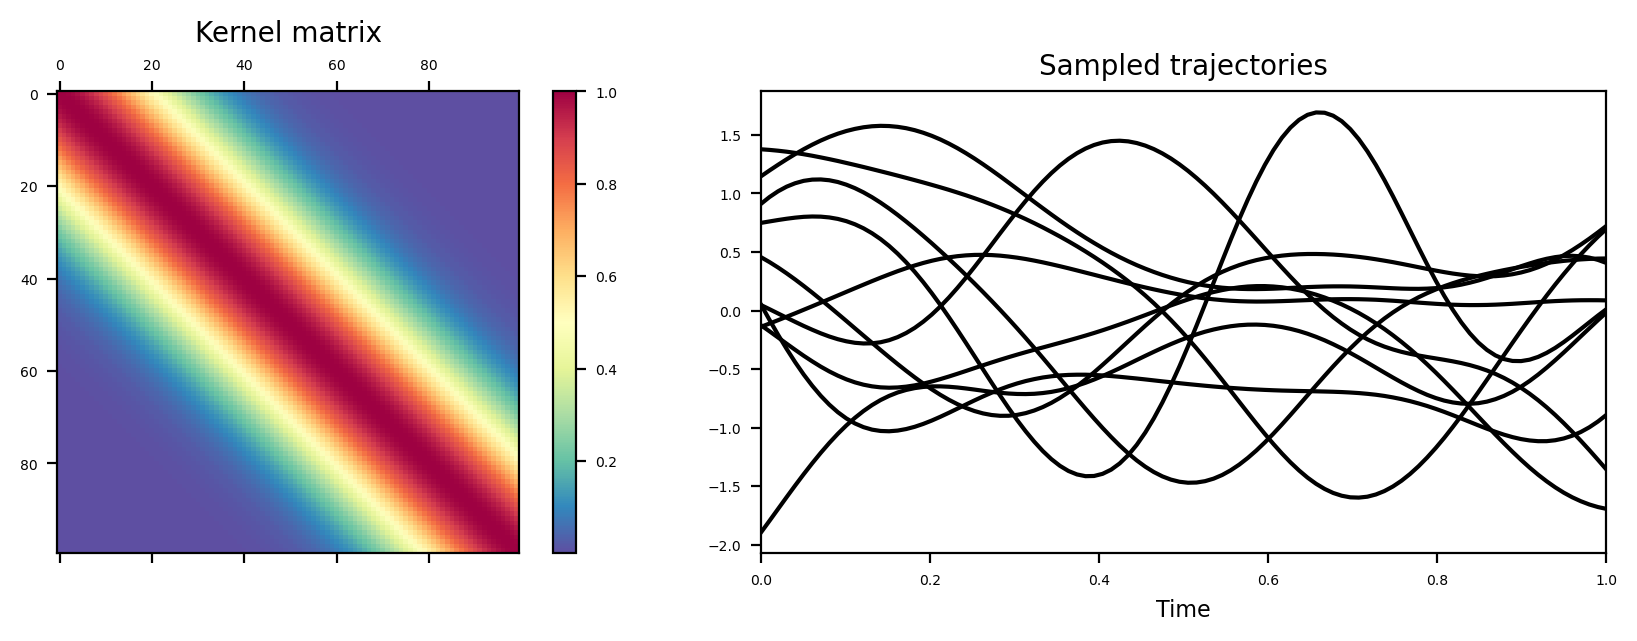

In [5]:
### Sample paths from GP prior
L = 100
times = np.linspace(start=0.0,stop=1.0,num=L).reshape((-1,1)) # [L x 1]
K = kernel_se(times,times,hyp={'gain':1.0,'len':1/4}) # [L x L]
K_chol = np.linalg.cholesky(K+1e-8*np.eye(L,L)) # [L x L]
D = 10
trajs = np.random.randn(D,L) @ K_chol.T # [D x L]
# Plot
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.matshow(K,fignum=False,cmap=plt.cm.Spectral_r)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Kernel matrix',fontsize=10)
plt.subplot(1,2,2)
for d_idx in range(D):
    plt.plot(times[:,0],trajs[d_idx,:],ls='-',color='k') 
plt.xlim([0,1])
plt.title('Sampled trajectories',fontsize=10)
plt.xlabel('Time',fontsize=8); plt.show()

### Forward Hilbert diffusion sampling

In [6]:
B,D,L = 5,3,100 # #batch, length, dimension
times = np.linspace(start=0.0,stop=1.0,num=L).reshape((-1,1)) # [L x 1]
K = kernel_se(times,times,hyp={'gain':1.0,'len':1/4}) # [L x L]
K_chol = np.linalg.cholesky(K+1e-8*np.eye(L,L)) # [L x L]
x_0 = np2torch(np.random.randn(1,L) @ K_chol.T) # [1 x L]
x_0_batch = torch.tile(input=x_0[None,:,:],dims=(B,D,1)) # [B x D x L]
# Different length parameters per dimension
lens = [1,0.1,0.01]
K_chols_np = np.zeros(shape=(D,L,L)) # [D x L x L]
for d_idx in range(D):
    K = kernel_se(times,times,hyp={'gain':1.0,'len':lens[d_idx]})
    K_chols_np[d_idx,:,:] = np.linalg.cholesky(K+1e-8*np.eye(L,L)) # [L x L]
K_chols = np2torch(K_chols_np) # [D x L x L]
# Forward sampling
steps = torch.linspace(start=0,end=dc['T']-1,steps=B).type(torch.long) # [B]
x_t,noise = forward_hilbert_diffusion_sample(
    x_0=x_0_batch,K_chols=K_chols,steps=steps,dc=dc,noise_rate=1.0)
# x_t:[B x D x L] / noise:[B x D x L]
print ("B:[%d] D:[%d] L:[%d]"%(B,D,L))
print ("x_t:%s noise:%s"%(x_t.shape,noise.shape))
print ("Forward sampling done.")

B:[5] D:[3] L:[100]
x_t:torch.Size([5, 3, 100]) noise:torch.Size([5, 3, 100])
Forward sampling done.


### Plot correlated noise and forward sampling results

In [7]:
x_0.shape

torch.Size([1, 100])

Plot correlated noises.


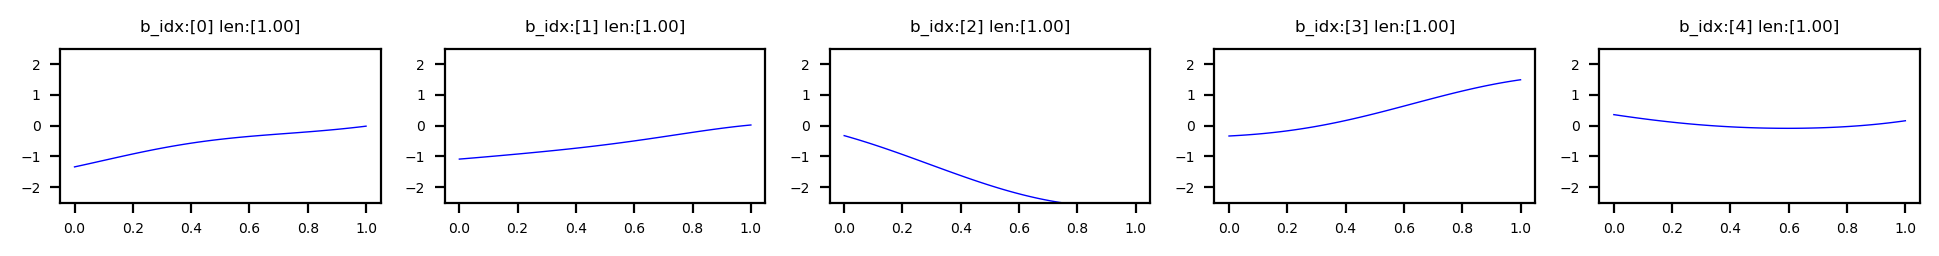

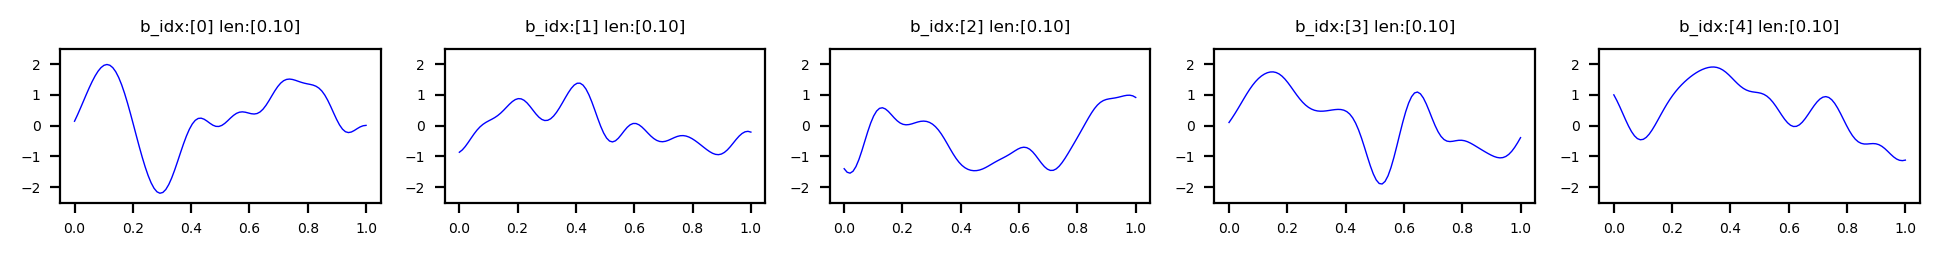

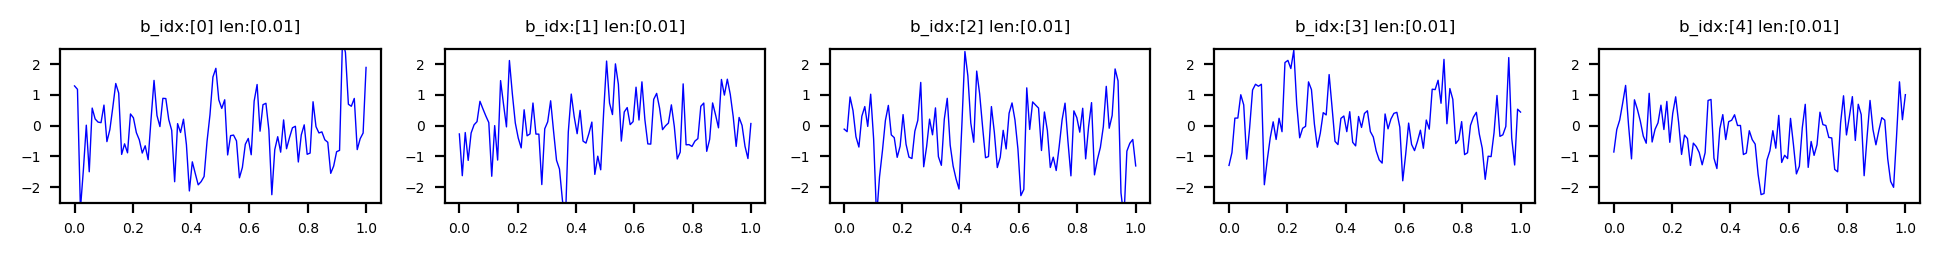

Plot forward sampling results.


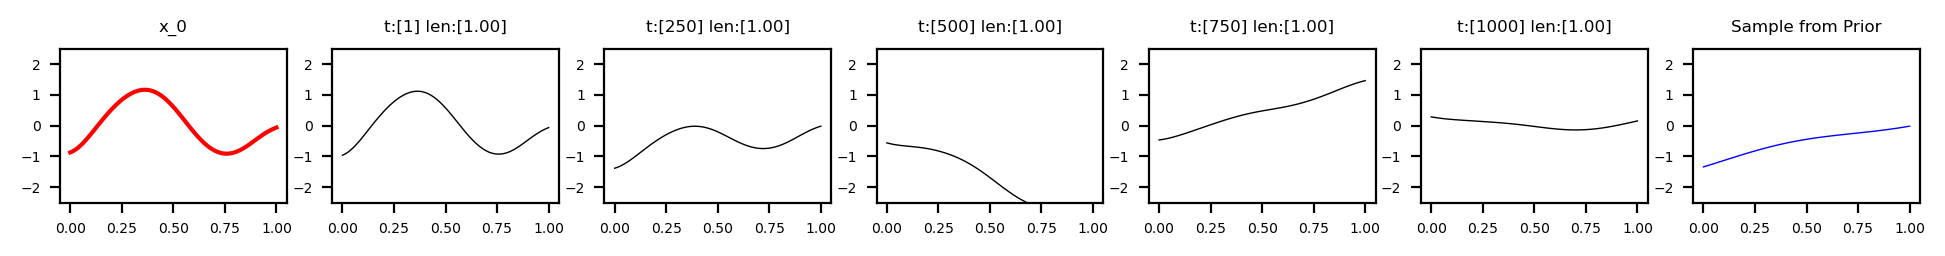

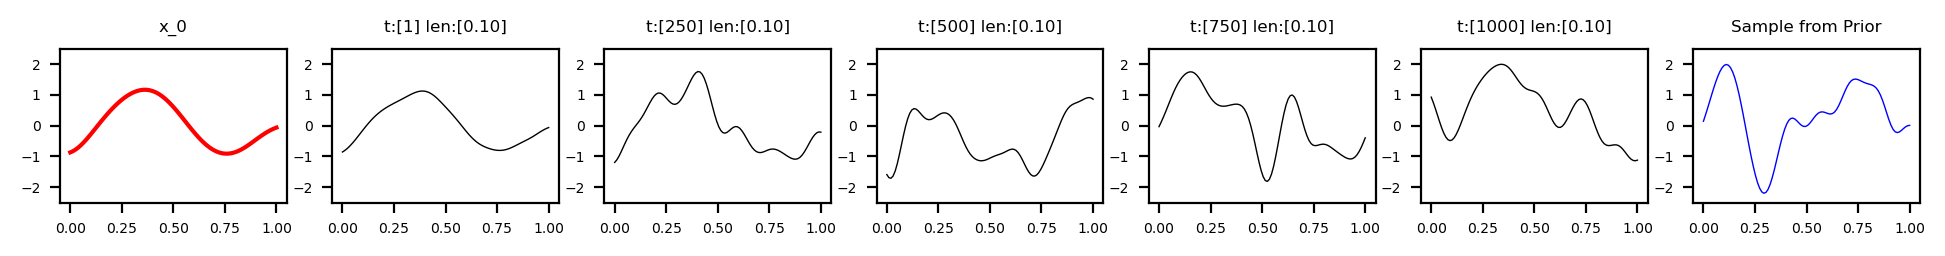

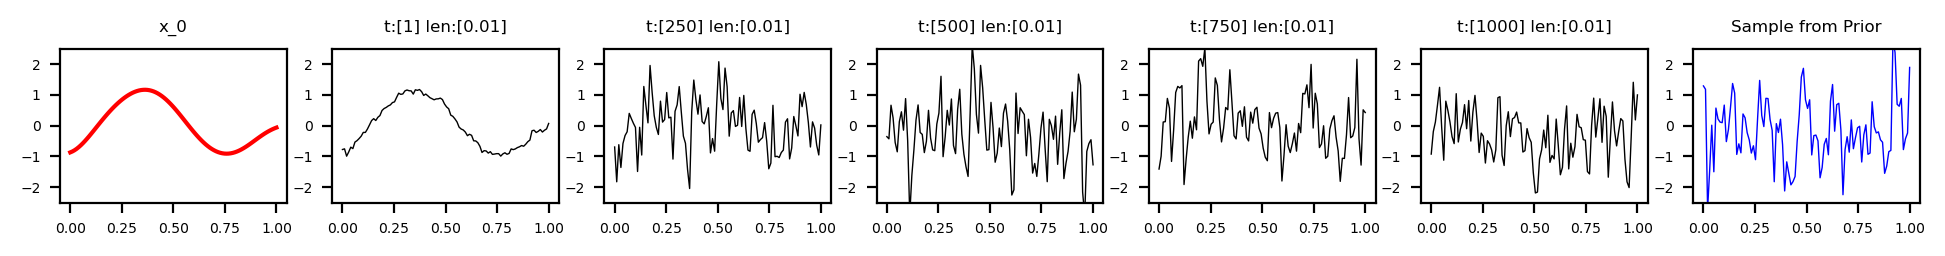

In [8]:
print ("Plot correlated noises.")
for d_idx in range(D):
    plt.figure(figsize=(12,1))
    for b_idx in range(B):
        plt.subplot(1,B,b_idx+1)
        plt.plot(times[:,0],noise[b_idx,d_idx,:],ls='-',color='b',lw=1/2)
        plt.ylim([-2.5,+2.5])
        plt.title('b_idx:[%d] len:[%.2f]'%(b_idx,lens[d_idx]),
                  fontsize=6)
    plt.show()
print ("Plot forward sampling results.")

for d_idx in range(D):
    plt.figure(figsize=(12,1))
    plt.subplot(1,B+2,1); plt.plot(times[:,0],torch2np(x_0)[0,:],ls='-',color='r')
    plt.ylim([-2.5,+2.5]); plt.title('x_0',fontsize=6)
    for b_idx in range(B):
        plt.subplot(1,B+2,b_idx+2); plt.plot(times[:,0],x_t[b_idx,d_idx,:],ls='-',color='k',lw=1/2)
        plt.ylim([-2.5,+2.5])
        plt.title('t:[%d] len:[%.2f]'%(torch2np(steps)[b_idx]+1,lens[d_idx]),
                  fontsize=6)
    plt.subplot(1,B+2,B+2); plt.plot(times,torch2np(noise[0,d_idx,:]),ls='-',color='b',lw=1/2)
    plt.ylim([-2.5,+2.5]); plt.title('Sample from Prior',fontsize=6); plt.show()

### Network

In [9]:
class SinPositionEmbeddingsClass(nn.Module):
    def __init__(self,dim=128,T=1000):
        super().__init__()
        self.dim = dim
        self.T = T
    @torch.no_grad()
    def forward(self,steps=torch.arange(start=0,end=1000,step=1)):
        device = steps.device
        half_dim = self.dim // 2
        embeddings = np.log(self.T) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = steps[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
    
class DenseBlockClass(nn.Module):
    def __init__(self,in_dim=10,out_dim=5,pos_emb_dim=10,actv=nn.ReLU(),
                 USE_POS_EMB=True):
        """
            Initialize
        """
        super(DenseBlockClass,self).__init__()
        self.in_dim      = in_dim
        self.out_dim     = out_dim
        self.pos_emb_dim = pos_emb_dim
        self.actv        = actv
        self.USE_POS_EMB = USE_POS_EMB
        self.dense1 = nn.Linear(self.in_dim,self.out_dim)
        self.bnorm1 = nn.BatchNorm1d(self.out_dim)
        self.dense2 = nn.Linear(self.out_dim,self.out_dim)
        self.bnorm2 = nn.BatchNorm1d(self.out_dim)
        self.pos_emb_mlp = nn.Linear(self.pos_emb_dim,self.out_dim)
        
    def forward(self,x,t):
        """
            Forward
        """
        h = self.bnorm1(self.actv(self.dense1(x))) # dense -> actv -> bnrom1 [B x out_dim]
        if self.USE_POS_EMB:
            h = h + self.pos_emb_mlp(t) # [B x out_dim]
        h = self.bnorm2(self.actv(self.dense2(h))) # [B x out_dim]
        return h

class DenseUNetClass(nn.Module):
    def __init__(self,
                 name        = 'dense_unet',
                 D           = 3,
                 L           = 100,
                 pos_emb_dim = 128,
                 h_dims      = [128,64],
                 z_dim       = 32,
                 actv        = nn.ReLU(),
                 USE_POS_EMB = True):
        """
            Initialize
        """
        super(DenseUNetClass,self).__init__()
        self.name        = name
        self.D           = D
        self.L           = L
        self.x_dim       = self.D * self.L
        self.pos_emb_dim = pos_emb_dim
        self.h_dims      = h_dims
        self.z_dim       = z_dim
        self.actv        = actv
        self.USE_POS_EMB = USE_POS_EMB
        # Initialize layers
        self.init_layers()
        
    def init_layers(self):
        """
            Initialize layers
        """
        self.layers = nn.ModuleDict()
        # Encoder
        h_prev = self.x_dim
        for h_idx,h_dim in enumerate(self.h_dims):
            self.layers['Enc_%02d'%(h_idx)] = DenseBlockClass(
                in_dim=h_prev,out_dim=h_dim,pos_emb_dim=self.pos_emb_dim,actv=self.actv,
                USE_POS_EMB = self.USE_POS_EMB)
            h_prev = h_dim
        self.layers['Enc_%02d'%(len(self.h_dims))] = DenseBlockClass(
            in_dim=self.h_dims[-1],out_dim=self.z_dim,pos_emb_dim=self.pos_emb_dim,actv=self.actv,
            USE_POS_EMB=self.USE_POS_EMB)
        # Map
        self.layers['Map'] = DenseBlockClass(
            in_dim=self.z_dim,out_dim=self.z_dim,pos_emb_dim=self.pos_emb_dim,actv=self.actv,
            USE_POS_EMB=self.USE_POS_EMB)
        # Decoder
        h_prev = self.z_dim
        for h_idx,h_dim in enumerate(self.h_dims[::-1]):
            self.layers['Dec_%02d'%(h_idx)] = DenseBlockClass(
                in_dim=h_prev,out_dim=h_dim,pos_emb_dim=self.pos_emb_dim,actv=self.actv,
                USE_POS_EMB = self.USE_POS_EMB)
            h_prev = 2*h_dim
        self.layers['Dec_%02d'%(len(self.h_dims))] = DenseBlockClass(
            in_dim=h_prev,out_dim=self.x_dim,
            pos_emb_dim=self.pos_emb_dim,actv=self.actv,USE_POS_EMB=self.USE_POS_EMB)
        # Out
        self.layers['Out'] = DenseBlockClass(
            in_dim=2*self.x_dim,out_dim=self.x_dim,pos_emb_dim=self.pos_emb_dim,actv=self.actv,
            USE_POS_EMB = self.USE_POS_EMB)
        # Time embedding
        self.layers['Pos_Emb'] = nn.Sequential(
                SinPositionEmbeddingsClass(dim=self.pos_emb_dim),
                nn.Linear(self.pos_emb_dim,self.pos_emb_dim),
                nn.GELU()
            )
    def forward(self,x,t):
        """
            Forward
        """
        net = x # [B x x_dim]
        # Positional Embedding
        pos_emb = self.layers['Pos_Emb'](t) 
        # Net
        self.nets = []
        # Encoder 
        self.enc_paths = []
        self.enc_paths.append(net)
        self.nets.append(net)
        for h_idx in range(len(self.h_dims)+1):
            net = self.layers['Enc_%02d'%(h_idx)](net,pos_emb)
            self.enc_paths.append(net)
            self.nets.append(net)
        # Map
        net = self.layers['Map'](net,pos_emb)
        self.nets.append(net)
        # Decoder
        self.dec_paths = []
        for h_idx in range(len(self.h_dims)+1):
            net = self.layers['Dec_%02d'%(h_idx)](net,pos_emb)
            net = torch.cat([self.enc_paths[len(self.h_dims)-h_idx],net],dim=1)
            self.dec_paths.append(net)
            self.nets.append(net)
        net = self.layers['Out'](net,pos_emb) # [B x DL]
        self.nets.append(net)
        return net
           
print ("Ready.")    

Ready.


### Instantiate Dense U-net

In [10]:
model = DenseUNetClass(D=1,L=100,pos_emb_dim=32,h_dims=[64],z_dim=32,actv=nn.GELU(), # nn.GELU(), nn.ReLU()
                       USE_POS_EMB=False)
print ("[%s] instantiated."%(model.name))

[dense_unet] instantiated.


### Define loss function 

In [11]:
def get_loss(model,x_0,K_chols,t,dc):
    """
        x_0: [B x D x L]
    """
    # Forward diffusion
    x_noisy,noise = forward_hilbert_diffusion_sample(
        x_0=x_0,K_chols=K_chols,steps=t,dc=dc,noise_rate=1.0) # [B x D x L]
    # Predict noise
    x_noisy_flat = x_noisy.reshape(x_noisy.shape[0],-1) # [B x DL]
    noise_pred = model(x_noisy_flat, t) # [B x DL]
    # Compute loss
    noise_pred_unflat = noise_pred.reshape_as(x_0) # [B x D x L]
    l1_loss = F.l1_loss(noise, noise_pred_unflat)
    l2_loss = F.mse_loss(noise, noise_pred_unflat)
    huber_loss = F.huber_loss(noise, noise_pred_unflat)
    loss = huber_loss
    return loss
print ("Ready")

Ready


### Train

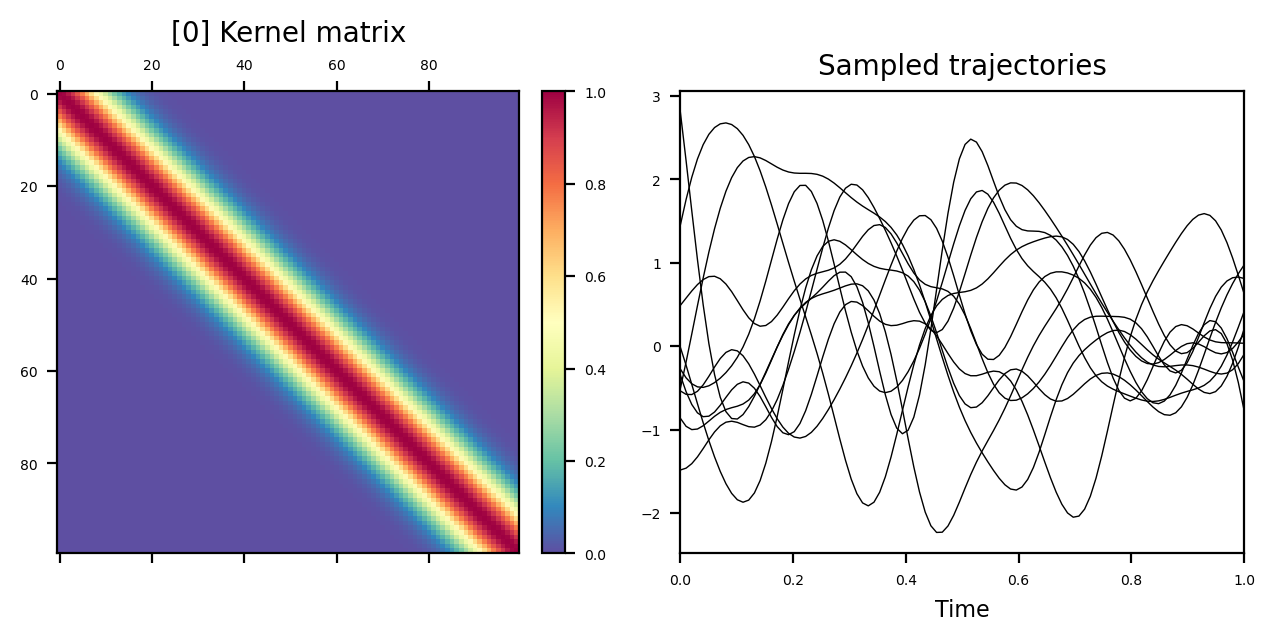

In [12]:
optm = torch.optim.Adam(model.parameters(),
                        lr=0.0001,betas=(0.9, 0.999),eps=1e-08)
L,D,BATCH_SIZE,MAX_ITER = 100,1,128,5000
x_0 # [D x L]
x_batch = torch.tile(x_0[None,:,:],dims=(BATCH_SIZE,1,1)) # [B x D x L]
# Different length parameters per dimension
lens = [0.1]
times = np.linspace(start=0.0,stop=1.0,num=L).reshape((-1,1)) # [L x 1]
Ks_np,K_chols_np = np.zeros(shape=(D,L,L)),np.zeros(shape=(D,L,L)) # [D x L x L]
for d_idx in range(D):
    K = kernel_se(times,times,hyp={'gain':1.0,'len':lens[d_idx]})
    Ks_np[d_idx,:,:] = K
    K_chols_np[d_idx,:,:] = np.linalg.cholesky(K+1e-10*np.eye(L,L)) # [L x L]
K_chols = np2torch(K_chols_np) # [D x L x L]
# Plot kernel matrix and sampled trajectories
for d_idx in range(D):
    K = Ks_np[d_idx,:,:]
    K_chol = K_chols_np[d_idx,:,:]
    n_traj = 10
    trajs = np.random.randn(n_traj,L) @ K_chol.T # [n_traj x L]
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.matshow(K,fignum=False,cmap=plt.cm.Spectral_r)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title('[%d] Kernel matrix'%(d_idx),fontsize=10)
    plt.subplot(1,2,2)
    for traj_idx in range(n_traj):
        plt.plot(times[:,0],trajs[traj_idx,:],ls='-',color='k',lw=1/2); 
    plt.xlim([0,1])
    plt.title('Sampled trajectories',fontsize=10)
    plt.xlabel('Time',fontsize=8); plt.show()

In [13]:
# Optimize
optm = torch.optim.Adam(
    model.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-06,weight_decay=1e-06)
model.train()
device = 'cpu'
for it in range(MAX_ITER):
    optm.zero_grad()
    t = torch.randint(0, dc['T'],(BATCH_SIZE,),device=device).long() # [B]
    loss = get_loss(model=model,x_0=x_batch,K_chols=K_chols,t=t,dc=dc)
    loss.backward()
    optm.step()
    if (it % 200) == 0:
        print ("[%d/%d] loss:[%.3f]"%(it,MAX_ITER,loss.item()))
print ("Done.")

[0/5000] loss:[0.672]
[200/5000] loss:[0.052]
[400/5000] loss:[0.034]
[600/5000] loss:[0.035]
[800/5000] loss:[0.036]
[1000/5000] loss:[0.038]
[1200/5000] loss:[0.041]
[1400/5000] loss:[0.032]
[1600/5000] loss:[0.027]
[1800/5000] loss:[0.029]
[2000/5000] loss:[0.030]
[2200/5000] loss:[0.030]
[2400/5000] loss:[0.022]
[2600/5000] loss:[0.022]
[2800/5000] loss:[0.029]
[3000/5000] loss:[0.029]
[3200/5000] loss:[0.026]
[3400/5000] loss:[0.028]
[3600/5000] loss:[0.026]
[3800/5000] loss:[0.032]
[4000/5000] loss:[0.022]
[4200/5000] loss:[0.029]
[4400/5000] loss:[0.032]
[4600/5000] loss:[0.017]
[4800/5000] loss:[0.022]
Done.


### Generation

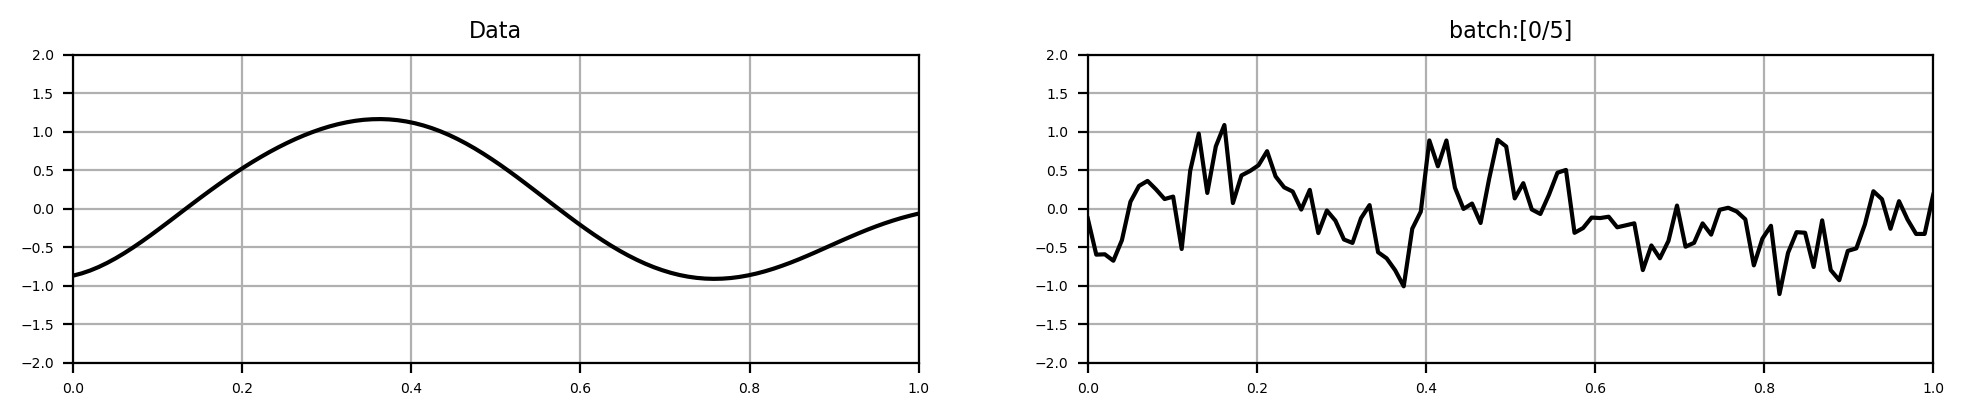

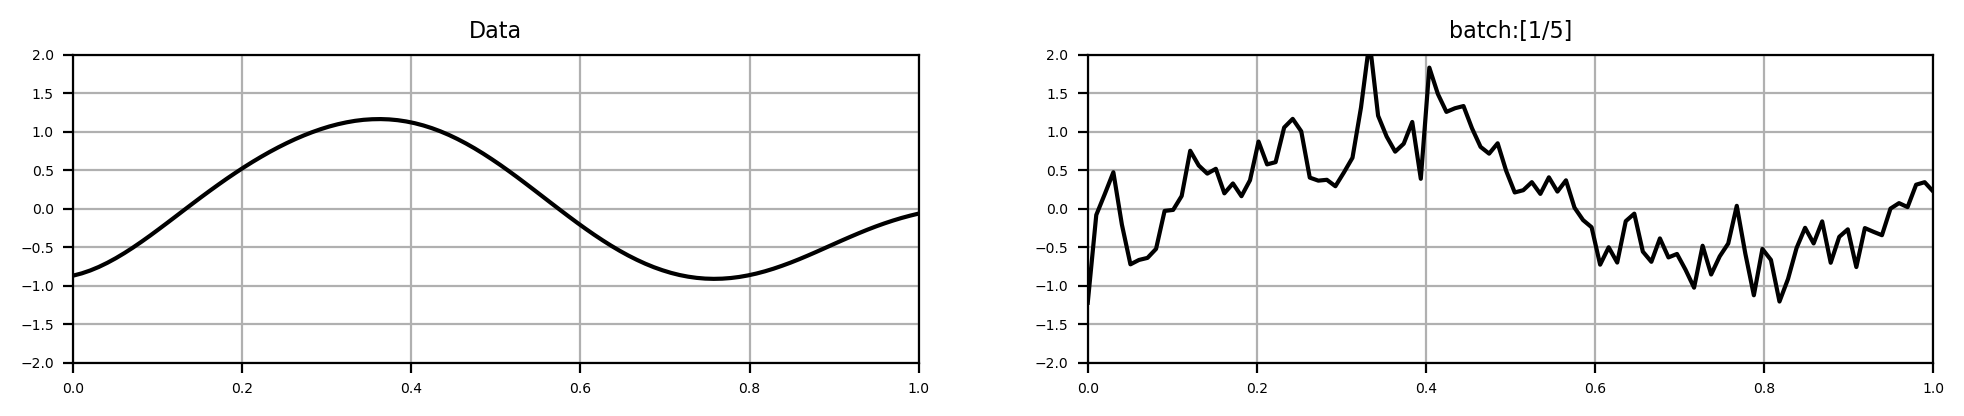

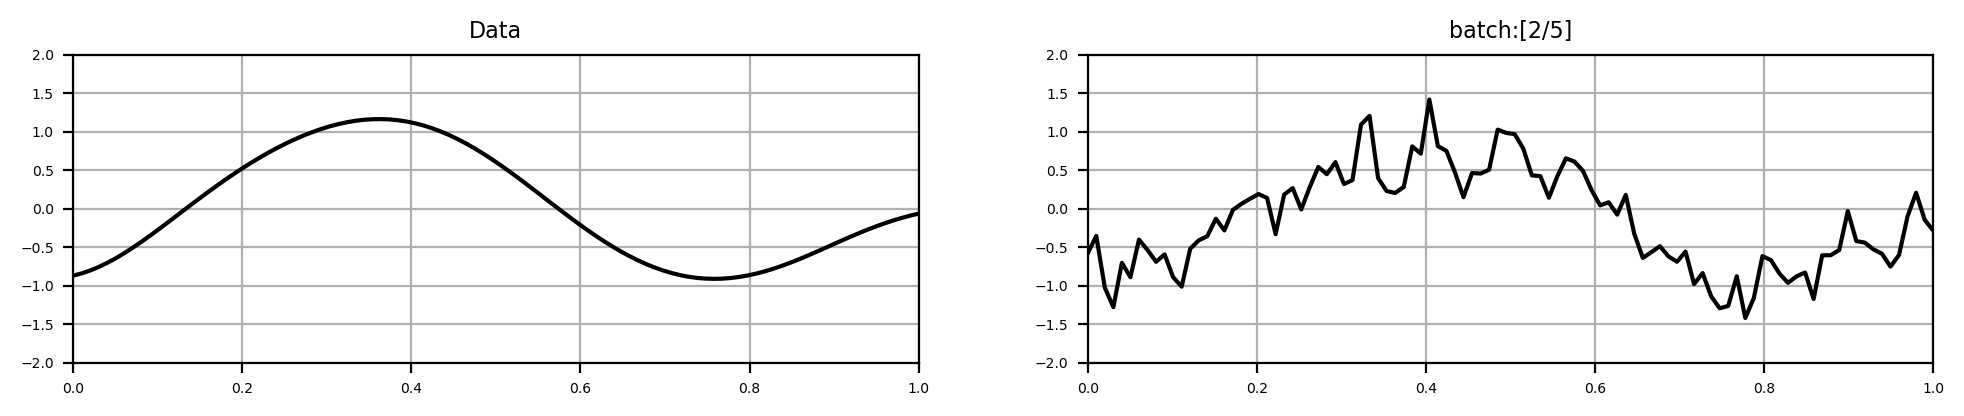

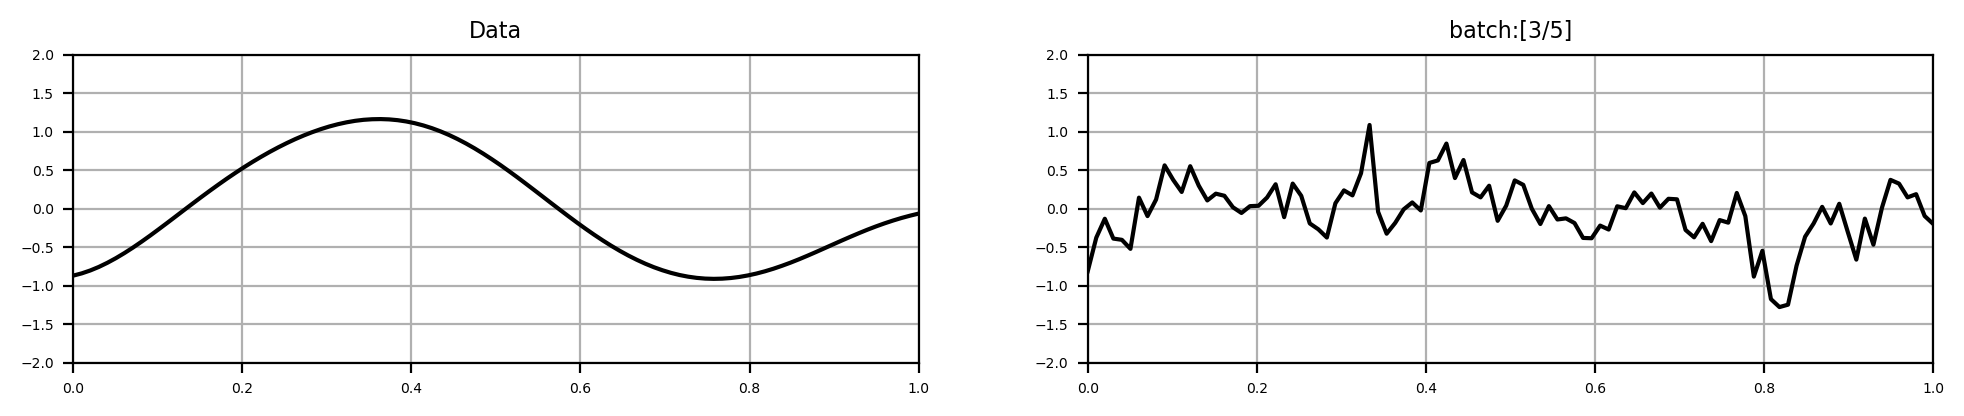

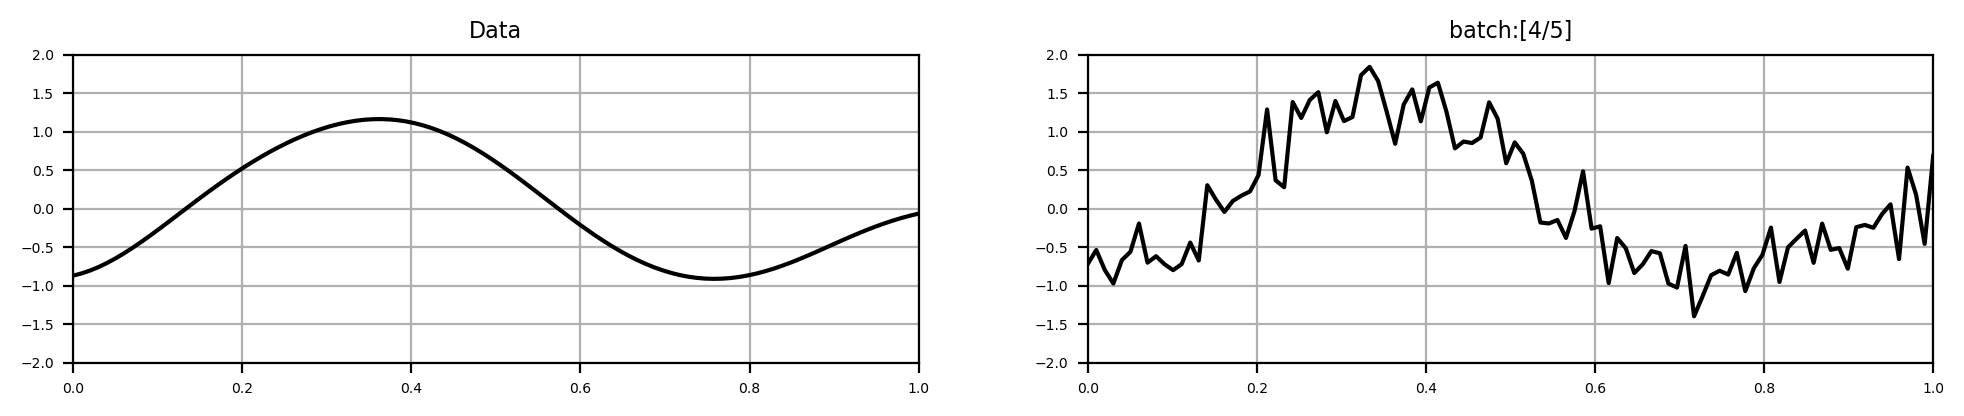

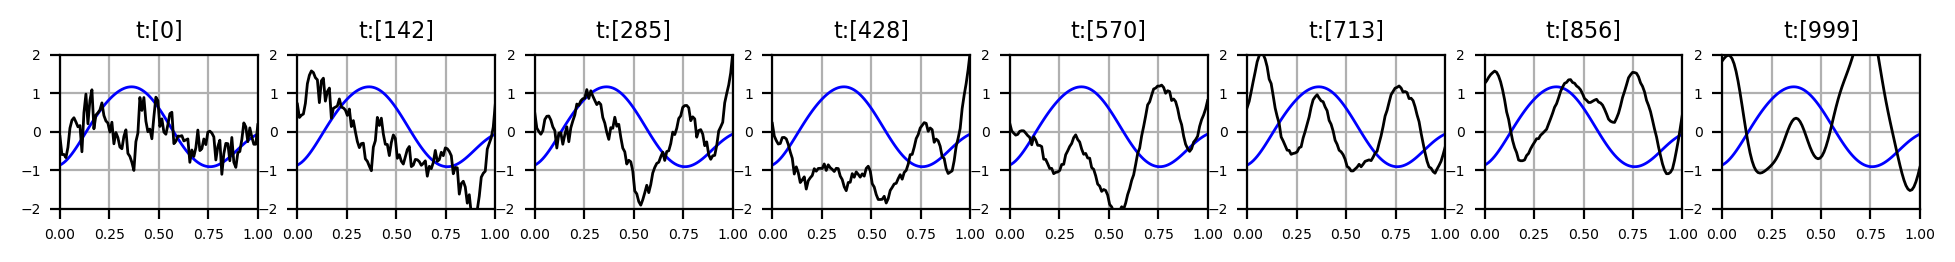

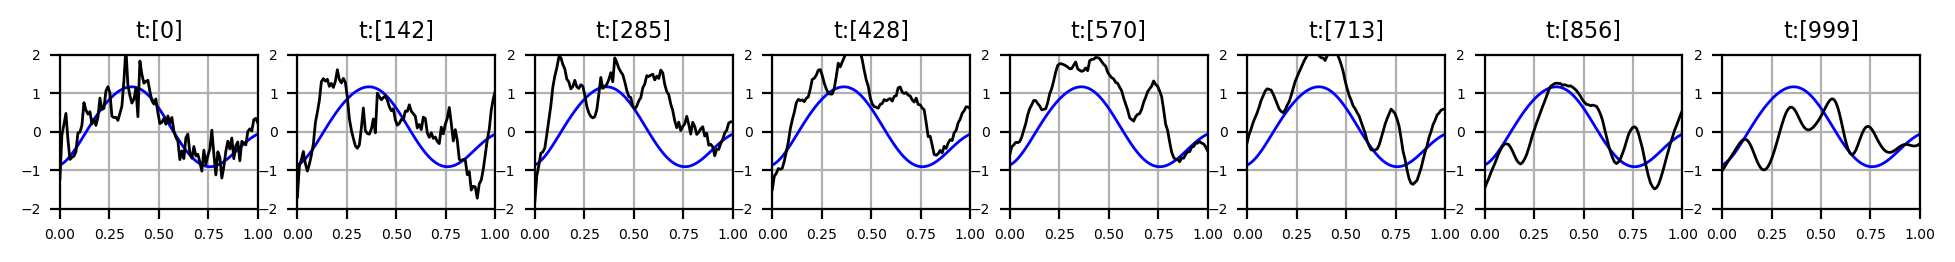

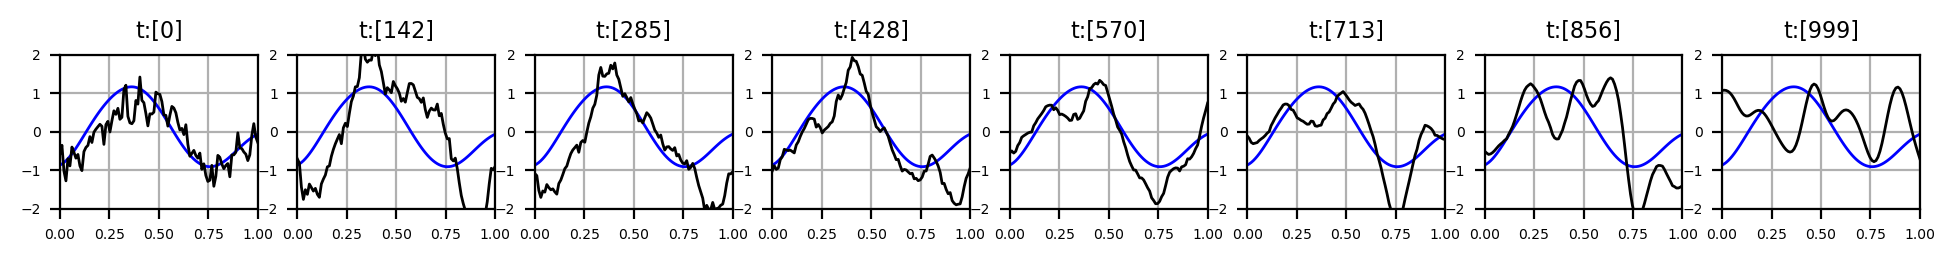

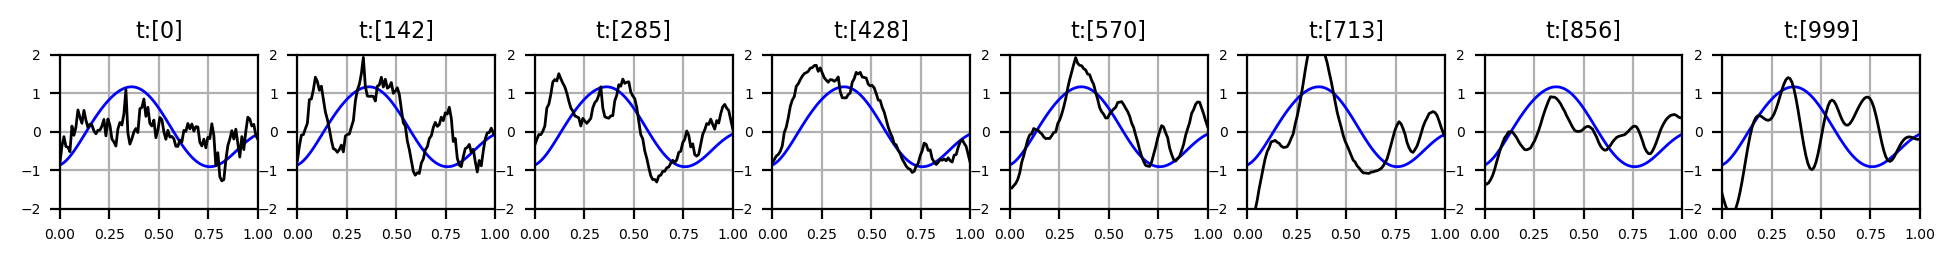

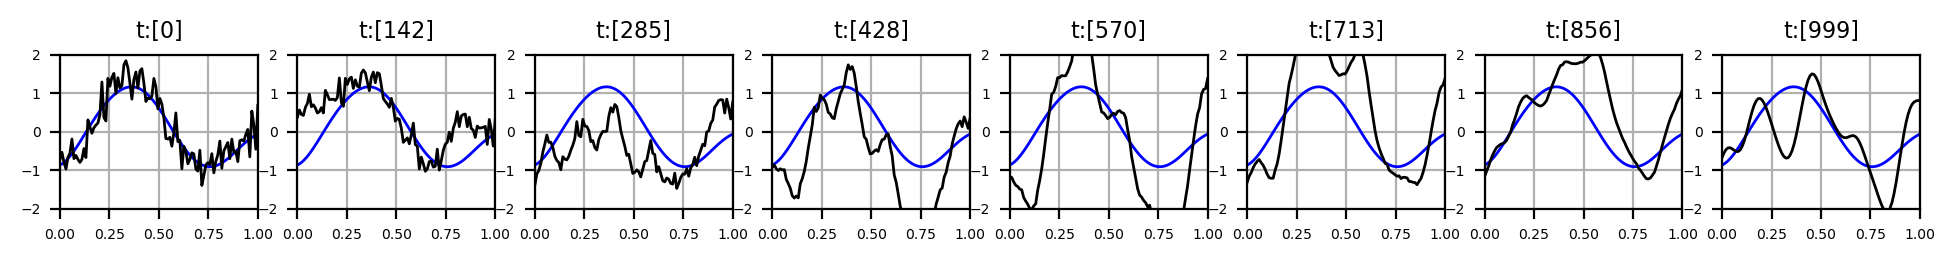

Ready.


In [14]:
model.eval()
device = 'cpu'
B,D,L = 5,1,100

# Sample x_T from prior
x_0_dummy = np2torch(np.zeros((B,D,L)))
steps = torch.zeros(B).type(torch.long) # [B]
_,noise = forward_hilbert_diffusion_sample(
    x_0=x_0_dummy,K_chols=K_chols,steps=steps,dc=dc,noise_rate=1.0)
x_T = noise.clone() # [B x D x L]
x_t = x_T.clone()

# Generate
x_ts = ['']*dc['T']
for t in range(0,dc['T'])[::-1]:
    t_torch = torch.full((1,), t,device=device,dtype=torch.long)
    x_t # [B x D x L]
    x_t_flat = x_t.reshape(x_t.shape[0],-1) # [B x DL]
    eps_t = model(x=x_t_flat,t=t_torch) # [B x DL]
    eps_t_unflat = eps_t.reshape_as(x_t) # [B x D x L]
    # Diffusion constants
    betas_t = gather_and_reshape(
        values=dc['betas'],steps=t_torch,x_shape=x_t.shape) # [B x 1 x 1]
    sqrt_one_minus_alphas_bar_t = gather_and_reshape(
        values=dc['sqrt_one_minus_alphas_bar'],steps=t_torch,x_shape=x_t.shape)
    sqrt_recip_alphas_t = gather_and_reshape(
        values=dc['sqrt_recip_alphas'],steps=t_torch,x_shape=x_t.shape)
    # Compute posterior mean
    model_mean_t = sqrt_recip_alphas_t * (
        x_t - betas_t*eps_t_unflat/sqrt_one_minus_alphas_bar_t
    ) # [B x D x L]
    # Compute correlated noise
    x_0_dummy = np2torch(np.zeros((B,D,L)))
    steps = torch.zeros(B).type(torch.long) # [B]
    _,noise_t = forward_hilbert_diffusion_sample(
        x_0=x_0_dummy,K_chols=K_chols,steps=steps,dc=dc,noise_rate=1.0)
    noise_t # [B x D x L]
    # Compute posterior variance
    posterior_variance_t = gather_and_reshape(
        values=dc['posterior_variance'],steps=t_torch,x_shape=x_t.shape)
    # Sample
    if t == 0: # last sampling, use mean
        x_t = model_mean_t
    else:
        x_t = model_mean_t + torch.sqrt(posterior_variance_t) * noise_t
    # Append
    x_ts[t] = x_t # [B x D x L]
    
# Plot generated trajectories
for b_idx in range(B):
    plt.figure(figsize=(12,2))
    plt.subplot(1,2,1)
    plt.plot(times[:,0],torch2np(x_0)[0,:],ls='-',color='k'); plt.grid('on')
    plt.title('Data',fontsize=8); plt.xlim(0,+1); plt.ylim(-2,+2)
    plt.subplot(1,2,2)
    plt.plot(times[:,0],torch2np(x_t)[b_idx,0,:],ls='-',color='k'); plt.grid('on')
    plt.title('batch:[%d/%d]'%(b_idx,B),fontsize=8); plt.xlim(0,+1); plt.ylim(-2,+2)
    plt.show()
    
# Plot how the trajectories are generated
for b_idx in range(B):
    plt.figure(figsize=(12,1))
    M = 8
    for subplot_idx,t in enumerate(np.linspace(0,dc['T']-1,M).astype(np.int64)):
        plt.subplot(1,M,subplot_idx+1)
        x_t = x_ts[t][b_idx,:,:]
        plt.plot(times[:,0],torch2np(x_0)[0,:],ls='-',color='b',lw=1) # GT 
        plt.plot(times[:,0],torch2np(x_t)[0,:],ls='-',color='k',lw=1) # generated
        plt.xlim(0,+1); plt.ylim(-2,+2); plt.grid('on')
        plt.title('t:[%d]'%(t),fontsize=8)
    plt.show()
print ("Ready.")